### 1 - EDA

In [2]:
from lxml import etree as ET
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
path_to_file = "../../pubmed23n1165.xml"

In [4]:
context = ET.iterparse(path_to_file, events=("start", "end"))

In [5]:
pubmed_article_count = 0

# Iterate through the XML elements
for event, elem in context:
    if elem.tag == "PubmedArticle":
        pubmed_article_count += 1

        # Extract information for the first 10 PubmedArticle elements
        if pubmed_article_count <= 3:
            pmid = elem.find(".//PMID")
            title = elem.find(".//ArticleTitle")
            abstract = elem.find(".//Abstract")

            if pmid is not None:
                print("PMID:", pmid.text)
            if title is not None:
                print("Title:", title.text)
            if abstract is not None:
                print("Abstract:")
                for abstract_text in abstract.findall("AbstractText"):
                    print("  AbstractText:", abstract_text.text)
            print("\n-----\n-----\n")
        else:
            break

PMID: 36434552
Title: Prognostic model for overall survival that includes the combination of platelet count and neutrophil-lymphocyte ratio within the first six weeks of sunitinib treatment for metastatic renal cell carcinoma.
Abstract:
  AbstractText: The association between the combination of platelet count and neutrophil-lymphocyte ratio (COP-NLR) at the time of adverse events during sunitinib treatment and prognosis is unclear, and prognostic models combining the prognostic factors of sunitinib have not been well studied. Thus, we developed a prognostic model that includes the COP-NLR to predict the prognosis of patients with metastatic renal cell carcinoma (mRCC) treated with sunitinib.
  AbstractText: We performed a retrospective cohort study of 102 patients treated with sunitinib for mRCC between 2008 and 2020 in three hospitals associated with Showa University, Japan. The primary outcome was overall survival (OS). The collected data included baseline patient characteristics, ad

In [6]:
data = []

# Iterate through the XML elements
for event, elem in tqdm(context):
    if elem.tag == "PubmedArticle":
        pubmed_article_count += 1

        pmid = elem.find(".//PMID")
        title = elem.find(".//ArticleTitle")
        abstract = elem.find(".//Abstract")

        if pmid is not None and title is not None and abstract is not None:
            pmid_text = pmid.text
            title_text = title.text
            abstract_texts = [abstract_text.text if abstract_text.text is not None else "" for abstract_text in abstract.findall("AbstractText")]
            abstract_text_concat = " ".join(abstract_texts)

            # Append the data to the list
            data.append((pmid_text, title_text, abstract_text_concat))

    # Clear the element to save memory
    elem.clear()

# Create a DataFrame with the data
df = pd.DataFrame(data, columns=["pmid", "title", "abstract"])

11750323it [00:17, 657516.80it/s]


In [7]:
df.memory_usage(deep=True).sum()/1024**2

45.977725982666016

In [8]:
df.head(), df.shape

(       pmid                                              title  \
 0  36434554  TALASUR trial: a single arm phase II trial ass...   
 1  36434555  HIV testing and associated factors among men (...   
 2  36434557  HIV is still a major public health problem amo...   
 3  36434558  Which style of duodenojejunostomy is better af...   
 4  36434556  Artificial intelligence to guide precision ant...   
 
                                             abstract  
 0  Urothelial carcinoma (UC) is the ninth most co...  
 1  Despite significant efforts made to prevent hu...  
 2  The burden of HIV is disproportionately higher...  
 3  Distal duodenal resections are sometimes neces...  
 4  Vast amounts of rapidly accumulating biologica...  ,
 (25487, 3))

In [9]:
df.dropna(inplace=True)
df.drop_duplicates(subset='pmid', inplace=True)

df["abstract_length"] = df["abstract"].apply(len)

df.isna().sum()

pmid               0
title              0
abstract           0
abstract_length    0
dtype: int64

In [10]:
df.shape

(25397, 4)

In [11]:
df['pmid'] = df['pmid'].astype(int)
df.shape

(25397, 4)

In [12]:
clean_df = df[df["abstract_length"] > 1000]
clean_df.shape

(17076, 4)

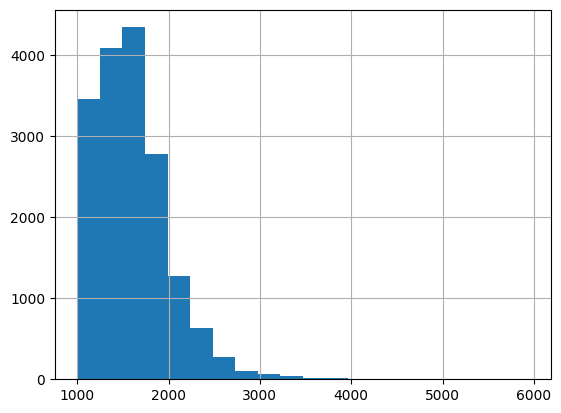

In [13]:
clean_df["abstract_length"].hist(bins=20)
plt.show()

In [21]:
a = clean_df[clean_df["pmid"] == 36434554]

In [28]:
a.iloc[0,2]

'Urothelial carcinoma (UC) is the ninth most commonly diagnosed cancer worldwide, with a 3.8/1 male to female ratio. Platinum-based chemotherapy is the first line standard of care for fit patients with advanced UC. However, despite a response rate (RR) for approximately half of patients receiving standard chemotherapy, durable responses are rare (median progression-free progression (PFS) around 8\xa0months). Recently, immune checkpoint inhibitors (ICI) have emerged as new therapeutic options. Among them, Avelumab, an anti-PD-L1 antibody, was assessed in maintenance treatment, demonstrating an overall survival improvement in the JAVELIN Bladder-100 phase III trial. These findings led to its approval as first line maintenance therapy for patients with locally advanced or metastatic UC who have not progressed on prior platinum-containing chemotherapy. However, disease progression as best response was noticed for 37% of patients under Avelumab as maintenance treatment. UC has targetable ge

In [23]:
a["abstract"]

0    Urothelial carcinoma (UC) is the ninth most co...
Name: abstract, dtype: object

### 2 - Load data into Postgres

In [44]:
# Data processing
from langchain.text_splitter import RecursiveCharacterTextSplitter
import pandas as pd
import os

# DB connection
from google.cloud.sql.connector import Connector
import sqlalchemy
from sqlalchemy import create_engine, text

# Embeddings
from vertexai.language_models import TextEmbeddingModel

# Utils
import time
from tqdm import tqdm
import numpy as np

In [45]:
class DataProcessor:
    def __init__(self, df, text_splitter):
        self.df = df
        self.text_splitter = text_splitter
        self.chunked = []
        
    def process(self):
        for index, row in self.df.iterrows():
            product_id = row["product_id"]
            desc = row["description"]
            splits = self.text_splitter.create_documents([desc])
            for s in splits:
                r = {"product_id": product_id, "content": s.page_content}
                self.chunked.append(r)
        return self.chunked

In [46]:
class EmbeddingGenerator:
    def __init__(self, model, batch_size):
        self.model = model
        self.batch_size = batch_size
        
    def generate_embeddings(self, chunked):
        for i in tqdm(range(0, len(chunked), self.batch_size)):
            request_data = [c["content"] for c in chunked[i: i + self.batch_size]]
            response = self.retry_with_backoff(self.model.get_embeddings, request_data)
            for c, e in zip(chunked[i: i + self.batch_size], response):
                c["embedding"] = e.values
                
    def retry_with_backoff(self, func, *args, retry_delay=5, backoff_factor=2):
        max_attempts = 10
        retries = 0
        for i in range(max_attempts):
            try:
                return func(*args)
            except Exception as e:
                print(f"error: {e}")
                retries += 1
                wait = retry_delay * (backoff_factor**retries)
                print(f"Retry after waiting for {wait} seconds...")
                time.sleep(wait)

In [67]:
class DatabaseInterface:
    def __init__(self, instance_connection_name, db_user, db_pass, db_name):
        self.instance_connection_name = instance_connection_name
        self.db_user = db_user
        self.db_pass = db_pass
        self.db_name = db_name
        self.connector = Connector()
        self.pool = self.create_pool()

    def get_conn(self):
        conn = self.connector.connect(
            self.instance_connection_name,
            "pg8000",
            user=self.db_user,
            password=self.db_pass,
            db=self.db_name
        )
        return conn

    def create_pool(self):
        return create_engine(
            "postgresql+pg8000://",
            creator=self.get_conn,
        )
    
    def run_query(self, query, fetch=True):
        with self.pool.connect() as connection:
            result = connection.execute(text(query))
            connection.commit() 
            if fetch:
                return result.fetchall()
            else:
                return None
            
    def insert_data_from_dataframe(self, dataframe, table_name):
        dataframe.to_sql(
            table_name,
            self.pool,
            if_exists='append',
            index=False,
            method='multi'
        )
        
    def create_table(self, table_name, columns):
        """
        Creates a table with the given name and columns.
        :param table_name: The name of the table
        :param columns: A dictionary where keys are column names and values are SQL data types
        """
        cols = ', '.join(f'{col} {dtype}' for col, dtype in columns.items())
        create_table_query = f'CREATE TABLE {table_name} ({cols});'
        self.run_query(create_table_query, fetch=False)

    def drop_table(self, table_name):
        """
        Drops the table with the given name.
        :param table_name: The name of the table
        """
        drop_table_query = f'DROP TABLE {table_name};'
        print(self.run_query(drop_table_query, fetch=False))

In [68]:
project_id = "steam-378309"
region = "europe-west3"
instance_name = "legalm"

DB_NAME = "pubmed"
DB_USER = "postgres"
DB_PASS = "bdpass"
DB_PORT = "5432"

INSTANCE_CONNECTION_NAME = f"{project_id}:{region}:{instance_name}"
print(f"Your instance connection name is: {INSTANCE_CONNECTION_NAME}")

Your instance connection name is: steam-378309:europe-west3:legalm


In [69]:
db_interface = DatabaseInterface(INSTANCE_CONNECTION_NAME, DB_USER, DB_PASS, DB_NAME)

In [70]:
# db_interface.run_query("CREATE EXTENSION IF NOT EXISTS vector", fetch=False)

In [71]:
pm_abstracts_fields = {"pmid": "BIGINT",
                       "title": "TEXT",
                       "abstract": "TEXT"}

pm_abstracts_embeddings_fields = {"pmid": "BIGINT",
                                 "title": "TEXT",
                                 "abstract": "TEXT",
                                 "embedding": "VECTOR(768)"}

In [72]:
table_query = """
        SELECT tablename 
        FROM pg_catalog.pg_tables 
        WHERE schemaname != 'pg_catalog' 
        AND schemaname != 'information_schema';
        """

In [73]:
db_interface.run_query(table_query)

[('pm_abstracts',), ('pm_abstracts_embeddings',)]

In [54]:
# db_interface.create_table("pm_abstracts", pm_abstracts_fields)
# db_interface.create_table("pm_abstracts_embeddings", pm_abstracts_embeddings_fields)

In [74]:
db_interface.run_query("TRUNCATE pm_abstracts", fetch=False)
db_interface.run_query("TRUNCATE pm_abstracts_embeddings", fetch=False)

In [ ]:
chunk_size = 100

for start in tqdm(range(0, len(clean_df), chunk_size)):
    end = start + chunk_size
    subset = clean_df.iloc[start:end]
    db_interface.insert_data_from_dataframe(subset, "pm_abstracts")

100%|██████████| 171/171 [00:25<00:00,  6.74it/s]


In [ ]:
db_interface.run_query("select count(distinct pmid) pmid from pm_abstracts")

[(17076,)]

In [80]:
text_splitter = RecursiveCharacterTextSplitter(
    separators=[".", "\n"],
    chunk_size=500,
    chunk_overlap=0,
    length_function=len,
)

chunked = []

for index, row in clean_df.iterrows():
    pmid = row["pmid"]
    title = row["title"]
    abstract = row["abstract"]
    splits = text_splitter.create_documents([abstract])
    for s in splits:
        r = {"pmid": pmid, "title": title, "abstract": s.page_content}
        chunked.append(r)

In [81]:
len(chunked)

70869